In [1]:
import os
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [2]:
# autograd, pot, gwot, pykeops, pathos, dcor
import matplotlib.pyplot as plt
import torch

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
from gwot import models
import sim
import gwot.bridgesampling as bs


import importlib
import models
import pred_models
import random

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
device

device(type='cpu')

In [4]:
PLT_CELL = 2.5

In [5]:
# set random seed
SRAND = 0
torch.manual_seed(SRAND)
np.random.seed(SRAND)

In [6]:
dim = 4
sim_steps = 250 # number of steps to use for Euler-Maruyama method
T = 5 # number of timepoints
t_final = 5. # simulation run on [0, t_final]


def Psi(x, t, dim = dim):
    velocity = -np.array([x[:, 2],
                          x[:, 3],
                          np.zeros_like(x[:, 0]),
                          np.zeros_like(x[:, 0])
                          ]).T
    return velocity
dPsi = Psi
Xi = lambda x, t: np.zeros_like(x)


D = 0.05 # diffusivity
def ic_func(N, d):
    init = np.zeros((N, d))
    init[:, 2] = 5 # x velocity
    init[:, 3] = 7 # y velocity

    return np.random.randn(N, d)*2*D + init

branching_rate = lambda x: 0*x[:, 0]

In [7]:
M = 100
N_vals = [64, 64]
N0 = 64
# setup simulation object
sims_all = [sim.Simulation(V = dPsi, dV = dPsi, Xi=Xi, birth_death = False, 
                          N = np.array([N0, ] + [N, ]*(T-2) + [N0, ]),
                          T = T, 
                          d = dim, 
                          D = D, 
                          t_final = t_final, 
                          ic_func = ic_func, 
                          pool = None) for N in N_vals]

# sample from simulation
for s in sims_all:
    s.sample(steps_scale = int(sim_steps/s.T));

In [8]:
sim_gt = copy.deepcopy(sims_all[0])
sim_gt.N = np.array([500, ]*T)
sim_gt.sample(steps_scale = int(sim_steps/sims_all[0].T));

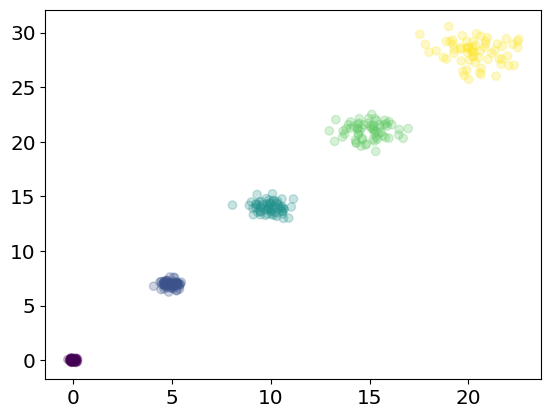

In [9]:
# plot samples
i = 0
plt.scatter(sims_all[i].x[:, 0], sims_all[i].x[:, 1], alpha = 0.25, c = sims_all[i].t_idx)
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

In [10]:
importlib.reload(models)
importlib.reload(pred_models)
torch.set_num_threads(8)

In [11]:
lamda_reg = .05
lamda_cst = 0.2
sigma_cst = 2.0/2
hid_weight = 5
sinkhorn_iters = 250
eta_final = 0.005
sigma_final = 0.5
temp_init = 100
temp_ratio = (1/5)**(1/5000)


s = sims_all[0]
obs_idx = 2 # How many variables are observed (always the first ones in the index)
dt = t_final/T

forwardMap = torch.tensor([
    [1., 0., 0., 0.],
    [0., 1., 0., 0.],
    [dt/2, 0., 1., 0.],
    [0., dt/2., 0, 1.],
    ],device=device)
backwardMap = torch.tensor([
    [1., 0., 0., 0.],
    [0., 1., 0., 0.],
    [-dt/2, 0., 1., 0.],
    [0., -dt/2., 0, 1.],
    ],device=device)


#Make forward/backward maps a class
class predictionMap():
    def forward(self,x):
        return x @ forwardMap #replace this with any desired function
        
    def backward(self,x):
        return x @ backwardMap #replace this with any desired function
    
pred = predictionMap() #If don't want to do prediction, can set to None
g = lambda x: x[:, 0:obs_idx] # observation function

fitType = 'Sinkhorn'
models_all = [pred_models.TrajLoss(pred, g, torch.randn(T, M, dim, device = device)*0.1,
                        torch.tensor(s.x[:], device = device), obs_idx,
                        torch.tensor(s.t_idx, device = device), 
                        dt = t_final/T, tau = D, sigma = None, M = M,
                        lamda_reg = lamda_reg, lamda_cst = lamda_cst, sigma_cst = sigma_cst, hid_weight = hid_weight,
                        branching_rate_fn = None,
                        sinkhorn_iters = 500, device = device,fitType=fitType,warm_start = True),
              models.TrajLoss(torch.randn(T, M, dim, device = device)*0.1,
                        torch.tensor(s.x[:], device = device), dim,
                        torch.tensor(s.t_idx, device = device), 
                        dt = t_final/T, tau = D, sigma = None, M = M,
                        lamda_reg = lamda_reg, lamda_cst = lamda_cst, sigma_cst = sigma_cst,
                        branching_rate_fn = None,
                        sinkhorn_iters = 500, device = device,warm_start = True)
                        ]

In [12]:
n_iters = 2000
outputs_all = [pred_models.optimize(models_all[0], n_iter = n_iters, eta_final = eta_final, tau_final = D, sigma_final = sigma_final, N = M, temp_init = temp_init, temp_ratio = temp_ratio, dim = dim, tloss = models_all[0], print_interval = 50,
                                    inspect_dynamics=True),
               models.optimize(models_all[1], n_iter = n_iters, eta_final = eta_final, tau_final = D, sigma_final = sigma_final, N = M, temp_init = temp_init, temp_ratio = temp_ratio, dim = dim, tloss = models_all[1], print_interval = 50)]


Iteration 0, Loss = 211.023, Primal loss = 217.825, Avg. iters = 0.000, eta = 0.500, temp = 100.000, Pred x vel avg. = 0.005, Pred y vel avg. = -0.041
Iteration 50, Loss = -9.013, Primal loss = -15.040, Avg. iters = 1.750, eta = 0.492, temp = 98.403, Pred x vel avg. = 2.656, Pred y vel avg. = 3.716
Iteration 100, Loss = -9.879, Primal loss = -16.169, Avg. iters = 2.250, eta = 0.484, temp = 96.832, Pred x vel avg. = 3.905, Pred y vel avg. = 5.433
Iteration 150, Loss = -10.167, Primal loss = -16.269, Avg. iters = 2.000, eta = 0.476, temp = 95.286, Pred x vel avg. = 4.517, Pred y vel avg. = 6.340
Iteration 200, Loss = -10.020, Primal loss = -16.060, Avg. iters = 1.500, eta = 0.469, temp = 93.765, Pred x vel avg. = 4.870, Pred y vel avg. = 6.703
Iteration 250, Loss = -10.022, Primal loss = -15.906, Avg. iters = 1.250, eta = 0.461, temp = 92.268, Pred x vel avg. = 5.034, Pred y vel avg. = 7.039
Iteration 300, Loss = -9.966, Primal loss = -15.580, Avg. iters = 1.500, eta = 0.454, temp = 90.7

Text(0.5, 1.0, 'Objective: primal')

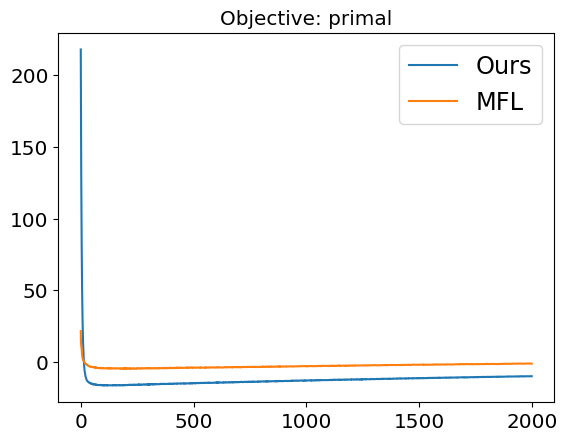

In [13]:
plt.plot(np.vstack([o[1] for o in outputs_all]).T)
plt.legend(["Ours", "MFL"])
plt.title("Objective: primal")

In [14]:
u = np.full(dim, 1); u[2:] = 0
u = u/np.linalg.norm(u)
N_paths_gt = 250
N_paths = 50
paths_gt = sim_gt.sample_trajectory(steps_scale = int(sim_steps/sim_gt.T), N = N_paths_gt)

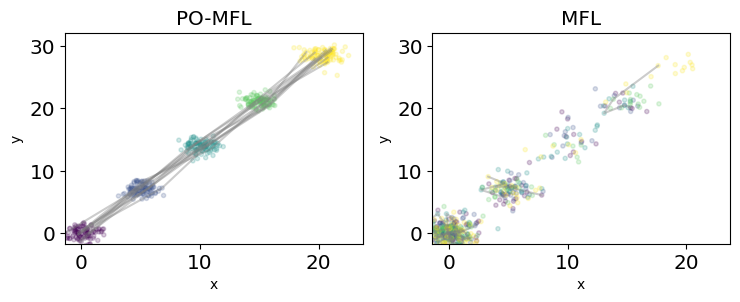

In [15]:
N_paths = 10

plt.figure(figsize = (3*PLT_CELL, 1.25*PLT_CELL))
for (i, m) in enumerate(models_all):
    plt.subplot(1, len(N_vals), i+1)
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = m.x.cpu().numpy(), 
                            get_gamma_fn = lambda i : m.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = T-1)
        plt.plot(paths[:, :, 0].T, paths[:, :, 1].T, color = 'grey', alpha =0.4);
        plt.scatter(m.x.reshape(-1, dim)[:, 0].cpu(), m.x.reshape(-1, dim)[:, 1].cpu(), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.2, marker = ".")
    plt.xlabel("x"); plt.ylabel("y")
    if i == 1:
        plt.title("MFL")
    else:
        
        plt.title("PO-MFL")
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
plt.tight_layout()

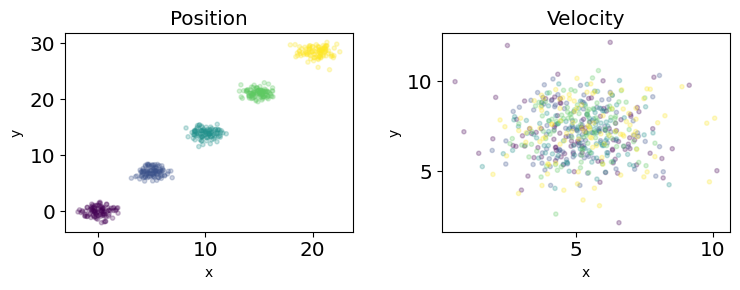

In [16]:
N_paths = 5
model = models_all[0]
plt.figure(figsize = (3*PLT_CELL, 1.2*PLT_CELL))

m = models_all[0]
titles = ["Position", "Velocity"]

for i in [0, 1]:
    plt.subplot(1, len(N_vals), i+1)
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = m.x.cpu().numpy(), 
                            get_gamma_fn = lambda i : m.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = T-1)
        plt.scatter(m.x.reshape(-1, dim)[:, 2 * i].cpu(), m.x.reshape(-1, dim)[:, 2* i + 1].cpu(), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25, marker = ".")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(titles[i])

plt.tight_layout()

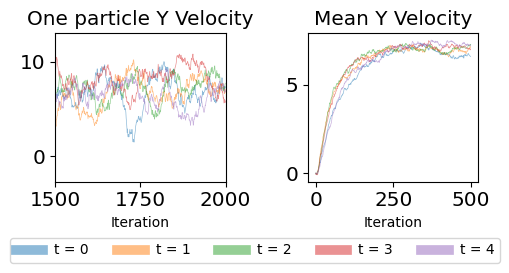

In [30]:
plt.subplots(1, 2, figsize = (2*PLT_CELL, PLT_CELL))

data = outputs_all[0][-1].cpu().numpy().round(3)

start = 1500
end = 2000

plt.subplot(1, 2, 1)
plt.plot(data[:end, :, 0, 3], linewidth = 0.5, alpha = 0.5)
plt.xlim(start, end)
plt.xticks(np.linspace(start, end, num=3, dtype=int))
labels = ["t = {}".format(i) for i in range(T)]
# plt.legend(labels, loc="upper right", fontsize=5)
plt.xlabel("Iteration")
plt.title("One particle Y Velocity")


data = outputs_all[0][-1].cpu().numpy().round(3)

start = 0
end = 500

plt.subplot(1, 2, 2)
plt.plot(data[:end, :, :, 3].mean(axis=-1), linewidth = 0.5, alpha = 0.5)
plt.xticks(np.linspace(start, end, num=3, dtype=int))
labels = ["t = {}".format(i) for i in range(T)]
# plt.legend(labels, fontsize=10, loc="lower right")
plt.xlabel("Iteration")
plt.title("Mean Y Velocity")

plt.tight_layout()

# legend outside

from matplotlib.legend_handler import HandlerLine2D


linewidth=7
def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(7)

plt.figlegend(labels, loc = 'outside lower center', ncol=5, labelspacing=0., fontsize = 10, bbox_to_anchor=(0.5, -0.1), handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
